# 1. Model Development Using Training Set

## 1.1 Model Development

In [6]:
library(ggplot2)
library(data.table)
library(zoo)
library(plyr)
library(pls)
library(stringr)


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'pls'

The following object is masked from 'package:stats':

    loadings



In [338]:
# Load processed data obtained from Data_Process.ipynb
data <- fread("data_winsorized_withoutNAreplace.csv")
#data <- fread("data_winsorized_NAreplaced.csv")

Read 74855 rows and 23 (of 23) columns from 0.022 GB file in 00:00:04


In [339]:
# Generate Momentum Factors
data <- data[, ctmp_returns := shift(fwd_returns, 1), by = stock]
data <- data[, len := .N, by = stock]
data <- data[, ":="(
            # Return of the most recent past month
            F21 = ctmp_returns, 
            # MA of past 3 months' returns
            F22 = ifelse(len >= 3, rollapply(ctmp_returns, 3, mean, fill = NA, align = "right"), as.numeric(NA)), 
            # MA of past 6 months' returns
            F23 = ifelse(len >= 6, rollapply(ctmp_returns, 6, mean, fill = NA, align = "right"), as.numeric(NA)), 
            # MA of past 12 months' returns
            F24 = ifelse(len >= 12, rollapply(ctmp_returns, 12, mean, fill = NA, align = "right"), as.numeric(NA))
), by = stock]
# remove useless columns
data <- data[, c(1:23, 26:29)] 

In [345]:
## Split into test/training set
# Since we are analyzing time series, for simplicity, take the observations on the first 70% days as training set,
# and the observations on the remaining 30% days as test set
split_date = length(unique(data$date)) * 0.7 # 84 out of 120 days
data_train <- data[as.numeric(substr(date, 2, 4)) <= split_date,]
data_test <- data[as.numeric(substr(date, 2, 4)) > split_date,]

# Order by date and stock
data_train <- data_train[order(stock, date),]
data_test <- data_test[order(stock, date),]

In [341]:
# Check if the training set is a good representative of the full dataset

# Function to compare statistics
compare_stats <- function(data_nm1, data_nm2){
    data1 <- get(data_nm1)
    data2 <- get(data_nm2)
    for (nm in colnames(data1)[2:dim(data1)[2]]){
        cat(nm, "\ndata_nm1:\n")
        print(summary(data1[[nm]]))
        cat("data_nm2:\n")
        print(summary(data2[[nm]]))
        cat("\n")
}}

# Compare
compare_stats("data", "data_train")

date 
data_nm1:
   Length     Class      Mode 
    74855 character character 
data_nm2:
   Length     Class      Mode 
    54104 character character 

fwd_returns 
data_nm1:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-28.2596  -3.8840   1.0417   0.9219   5.7935  30.8352 
data_nm2:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-28.2596  -4.2955   1.0121   0.8719   6.0889  30.8352 

F01 
data_nm1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.2681  0.8650  1.5891  2.1758  2.8376  7.1494     606 
data_nm2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.2681  0.8082  1.4773  2.0759  2.6912  7.1494     512 

F02 
data_nm1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   2.000   3.000   3.775   5.000   9.000     202 
data_nm2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   2.000   3.000   3.805   6.000   9.000     143 

F03 
data_nm1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1703    4887

In [347]:
## Standardization
# Standardize non-categorical factors
means <- colMeans(data_train[, c(3:4, 6:13, 15:27)], na.rm = T)
sds <- apply(data_train[, c(3:4, 6:13, 15:27)], 2, sd, na.rm=TRUE)

# Save original fwd_returns for backtest calculation
fwd_returns_train <- data_train[["fwd_returns"]]/100
fwd_returns_test <- data_test[["fwd_returns"]]/100

# The out-sample features should also be normalized using in-sample mean and std
normal <- function(data, means = means, sds = sds){
    for (i in c(3:4, 6:13, 15:27)){
        nm = colnames(data)[i]
        data[[i]] <- (data[[i]] - means[nm])/ sds[nm]
}
    return (data)
}

data_train <- normal(data_train, means, sds)
data_test <- normal(data_test, means, sds)

In [264]:
summary(data_train)

    stock               date            fwd_returns            F01         
 Length:54104       Length:54104       Min.   :-2.92129   Min.   :-1.0088  
 Class :character   Class :character   1st Qu.:-0.51819   1st Qu.:-0.7074  
 Mode  :character   Mode  :character   Median : 0.01406   Median :-0.3340  
                                       Mean   : 0.00000   Mean   : 0.0000  
                                       3rd Qu.: 0.52315   3rd Qu.: 0.3434  
                                       Max.   : 3.00471   Max.   : 2.8311  
                                                          NA's   :512      
      F02             F03               F04               F05         
 Min.   :0.000   Min.   :-0.7084   Min.   :-1.0113   Min.   :-1.7225  
 1st Qu.:2.000   1st Qu.:-0.5817   1st Qu.:-0.7022   1st Qu.:-0.6772  
 Median :3.000   Median :-0.3787   Median :-0.3052   Median :-0.0362  
 Mean   :3.805   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:6.000   3rd Qu.: 0.0776   3r

- ## Model 1

- ### Univariate Regressions
#### Elementary study of the predictive power of each single variable through univariate regressions.
#### And we can check whether their performance in the multi-variate regressions meet our expectation (observations here).

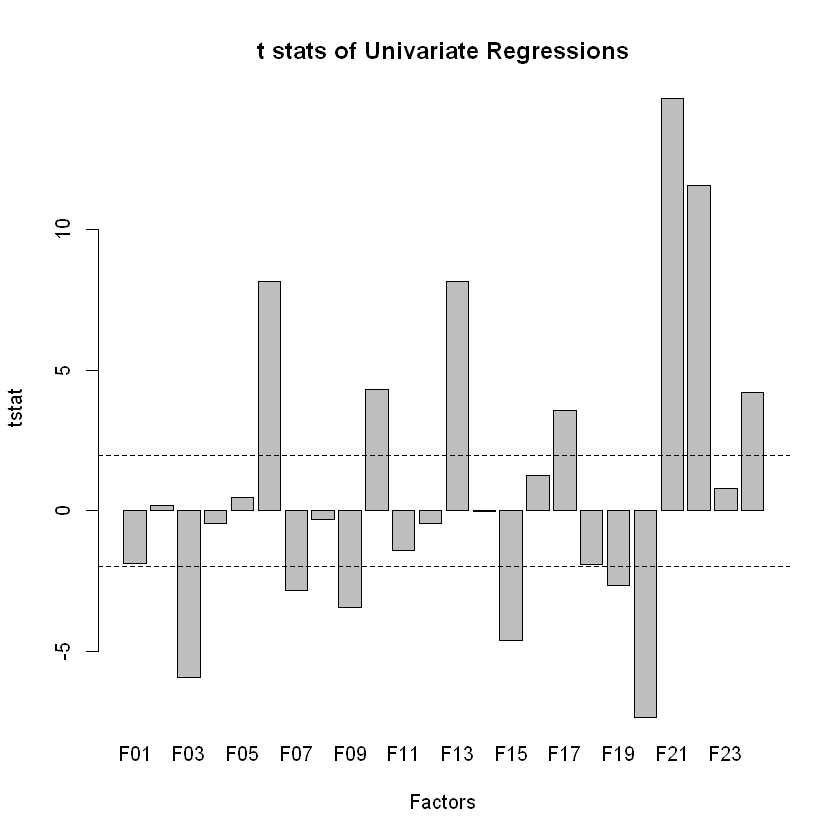

In [241]:
# List contains names of independent variables
factor_str_list = c()
for (i in c(1:24)) {
    factor_str_list = c(factor_str_list, paste('F', str_pad(as.character(i), 2, side = 'left', pad = '0'), sep=''))
}

# Matrix to store t values
tstat <- matrix(NA, 24, 1)
colnames(tstat) <- "t_stat"
rownames(tstat) <- factor_str_list

for (i in c(1:24)) {
    factor_string = factor_str_list[i]
    data_train[['x']] = data_train[[factor_string]]
    tstat[i,1] <- summary(lm(fwd_returns ~ x, na.action = na.exclude, data_train))$coef[2,3]
}

# Plot t_stats
barplot(tstat[,1], ylab = "tstat", xlab = "Factors", main = "t stats of Univariate Regressions")
abline(h = c(-1.96, 1.96), lty = 2)

- ### Multi-variate Regressions
#### Take the interaction of factors into account

In [247]:
data_train <- data_train[, c(1:27)] # remove useless columns

In [248]:
# First, start from putting all factors into the multi-variate regression
summary(lm(fwd_returns ~ ., na.action = na.exclude, data_train[, c(3:27)]))


Call:
lm(formula = fwd_returns ~ ., data = data_train[, c(3:27)], na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6917 -0.5250  0.0286  0.5408  3.7404 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.584e-02  2.532e-02   1.021  0.30738    
F01         -3.614e-03  7.817e-03  -0.462  0.64383    
F02          9.325e-06  2.197e-03   0.004  0.99661    
F03         -1.170e-02  1.323e-02  -0.884  0.37652    
F04         -1.947e-02  1.117e-02  -1.743  0.08139 .  
F05          6.465e-02  1.552e-02   4.166 3.11e-05 ***
F06         -2.240e-01  1.427e-02 -15.700  < 2e-16 ***
F07          5.792e-03  1.219e-02   0.475  0.63460    
F08         -3.976e-04  5.528e-03  -0.072  0.94266    
F09          1.090e-02  1.832e-02   0.595  0.55182    
F10         -2.774e-03  1.029e-02  -0.270  0.78739    
F11         -3.196e-03  4.108e-03  -0.778  0.43659    
F12         -1.678e-02  5.947e-03  -2.821  0.00479 ** 
F13          6.830e-02  6.844e

- #### Feature Selection

In [249]:
# Manual selection
data_train1 <- data_train[, c(1:3, 8:9, 15:18, 24:26)]
summary(lm(fwd_returns ~ ., na.action = na.exclude, data_train1[, c(3:12)]))
data_train1 <- data_train1[, c(1:5, 7, 10:12)]
summary(lm(fwd_returns ~ ., na.action = na.exclude, data_train1[, c(3:9)])) # F05, F06, F13, F21, F22, F23 remain to be significant


Call:
lm(formula = fwd_returns ~ ., data = data_train1[, c(3:12)], 
    na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8308 -0.5209  0.0300  0.5378  3.7391 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0020319  0.0045426  -0.447    0.655    
F05          0.0428651  0.0059437   7.212  5.6e-13 ***
F06         -0.1766318  0.0119193 -14.819  < 2e-16 ***
F12         -0.0057947  0.0048350  -1.198    0.231    
F13          0.0460021  0.0051025   9.016  < 2e-16 ***
F14          0.0038076  0.0046583   0.817    0.414    
F15          0.0006425  0.0048765   0.132    0.895    
F21          0.2345260  0.0127018  18.464  < 2e-16 ***
F22          0.0675040  0.0074245   9.092  < 2e-16 ***
F23         -0.0999096  0.0076771 -13.014  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.004 on 49044 degrees of freedom
  (5050 observations deleted due to missingness)
Multiple R-sq


Call:
lm(formula = fwd_returns ~ ., data = data_train1[, c(3:9)], na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7711 -0.5231  0.0294  0.5391  3.7393 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.002984   0.004540  -0.657    0.511    
F05          0.038822   0.005688   6.825  8.9e-12 ***
F06         -0.170560   0.011806 -14.447  < 2e-16 ***
F13          0.042622   0.004728   9.015  < 2e-16 ***
F21          0.226936   0.012572  18.051  < 2e-16 ***
F22          0.064519   0.007385   8.736  < 2e-16 ***
F23         -0.094545   0.007604 -12.434  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.008 on 49491 degrees of freedom
  (4606 observations deleted due to missingness)
Multiple R-squared:  0.01351,	Adjusted R-squared:  0.01339 
F-statistic: 112.9 on 6 and 49491 DF,  p-value: < 2.2e-16


In [ ]:
# Due to time limit, manual selection is used here. Otherwise, we can also try stepwise methods based on AIC/SIC criteria, and Lasso. 
# Ridge regression can also be used to deal with possible multi-collinearity

In [336]:
# Prediction
lm1 <- lm(fwd_returns ~ ., na.action = na.exclude, data_train1[, c(3:9)])

predict_ret <- function(model, factors, data, org_fwd_ret){
    predict1 <- predict(model, factors)
    prediction_data <- data[, c(1:3)]
    prediction_data[["fwd_returns_predict"]] <- predict1
    prediction_data[[org_fwd_ret]] <- get(org_fwd_ret)
    prediction_data <- prediction_data[! is.na(fwd_returns_predict),]
    
    return (prediction_data)
}

IS_factors1 <- data_train1[, c(4:9)]
prediction_data1 <- predict_ret(lm1, IS_factors1, data_train1, "fwd_returns_train")
head(prediction_data1)
dim(prediction_data1)
length(unique(prediction_data1$date))

stock,date,fwd_returns,fwd_returns_predict,fwd_returns_train
S001,D064,-0.2203888,-0.01124293,-0.01325843
S001,D065,-1.2982949,-0.03257384,-0.12074869
S001,D066,0.1572769,-0.06944440,0.02440291
S001,D067,-1.2589701,-0.01878417,-0.11682717
S001,D068,-2.9212927,-0.07015031,-0.28259623
S001,D069,3.0047056,-0.27743444,0.30835237


[1] 49498     5

[1] 79

- ## Model 2

In [ ]:
# Use industry-ranked variables instead of raw variables, considering some variables may have different performance/nature 
# for different industires
# Code to rank variables within the sector category that the stock belongs to:
# data_train[, var_sec_ranked := rank(var, na.last = "keep")/ max(rank(var, na.last = "keep"), na.rm = T) - 0.5, by = list(date, F02)]

# The remaining process for predictive modeling and backtesing should be very similar to that of model 1

## 1.2 Robustness Check

- ### By Sector

- ### By Year
#### Given the nature of this particular data set, we can regard 12 consecutive month as a year unit.
#### The year defined here may not start from January, but still covers the full cycle of a year, so that any seasonality (or other calendar related patterns) of the strategies' performance will still be taken care of.

- ### Orthogonalized Against Common Risk Factors (Eg. BARRA Factors) To See If Our Factors Add Any Marginal Value

# 2. Model Selection

## 2.1  In-Sample Backtest for Single Strategies

### Compare in-sample performance of different strategies

In [361]:
decide_long_short <- function(prediction_data){
    prediction_data <- prediction_data[, num_of_stock_on_mkt := .N, by = date]
    # Avg 627 stock per day, thus we can rank the market by predicted fwd_ret, then long the top 10% and short the bottom 10%
    cat("Average number of stocks in the whole market per day:\n")
    print(mean(prediction_data[["num_of_stock_on_mkt"]]))
    # Rank the whole mkt on each day, the range of ranking is [-0.5, 0.5]
    prediction_data <- prediction_data[, fwd_return_predict_mkt_rank := rank(fwd_returns_predict, na.last = "keep")/ 
                                         max(rank(fwd_returns_predict, na.last = "keep"), na.rm = T) - 0.5, by = date]
    prediction_data <- prediction_data[, short_or_long := ifelse(fwd_return_predict_mkt_rank >= 0.4, 1, 
                                                                   ifelse(fwd_return_predict_mkt_rank <= -0.4, -1, 0))]
    return (prediction_data)
}

prediction_data1 <- decide_long_short(prediction_data1)

Average number of stocks in the whole market per day:
[1] 627.1516


In [308]:
head(prediction_data1)

stock,date,fwd_returns,fwd_returns_predict,fwd_returns_train,num_of_stock_on_mkt,fwd_return_predict_mkt_rank,short_or_long,num_of_long,num_of_short,portfolio_monthly_ret,log_portfolio_monthly_ret
S001,D064,-0.2203888,-0.01124293,-0.01325843,613,0.20636215,0,62,61,0.02345413,0.02318330
S001,D065,-1.2982949,-0.03257384,-0.12074869,610,0.06065574,0,62,61,0.02850957,0.02811073
S001,D066,0.1572769,-0.06944440,0.02440291,610,0.01639344,0,62,61,0.04142659,0.04059150
S001,D067,-1.2589701,-0.01878417,-0.11682717,607,0.31054366,0,61,60,-0.04161101,-0.04250154
S001,D068,-2.9212927,-0.07015031,-0.28259623,605,0.22231405,0,61,60,0.02997955,0.02953895
S001,D069,3.0047056,-0.27743444,0.30835237,605,-0.48347107,-1,61,60,-0.06158898,-0.06356723


In [362]:
# Calculate monthly portfolio returns 
cal_port_ret <- function(prediction_data){
    # Number of stocks in long and short portfolio respectively
    prediction_data <- prediction_data[, ":="(
                                                num_of_long = sum(short_or_long == 1),
                                                num_of_short = sum(short_or_long == -1))
                                          , by =date]
    # Use un-standardized fwd_ret to calculate portfolio returns.
    # A long-short portfolio is built here, which is market neutral in the sense that equal amount of money are invested 
    # in long and short portfolios respectively.
    # For simplicity, use equal weight within long and short portfolio respectively here.
    # Assume the returns in this dataset are simple returns.

    # Aggregate across portfolio
    prediction_data <- prediction_data[, portfolio_monthly_ret := 1/num_of_long * sum(ifelse(short_or_long == 1, fwd_returns_train, 0)) 
                                         - 1/num_of_short * sum(ifelse(short_or_long == -1, fwd_returns_train, 0)), by = date]
        
    return (prediction_data)
}

prediction_data1 <- cal_port_ret(prediction_data1)

In [363]:
length(unique( prediction_data1[["portfolio_monthly_ret"]]))

[1] 79

In [369]:
# Sharpe Ratio
cal_SR <- function(prediction_data){
    # Since market neutral portfolio has no market (systematic) risk exposure, its benchmark should be risk free rate
    # US 10-year traesury yield is about 3% annually

    # Monthly SR
    # Transform simple returns to log returns
    prediction_data <- prediction_data[, log_portfolio_monthly_ret := log(1 + portfolio_monthly_ret)]
    rf = 0.03
    ret_sd <- sd(prediction_data[["log_portfolio_monthly_ret"]])
    ret_mean <- mean(prediction_data[["log_portfolio_monthly_ret"]])         
    SR = (ret_mean - rf / 12) / ret_sd
    # Annualize
    SR = sqrt(12) * SR
    cat("Sharpe Ratio:\n")
    print(SR)
    
    cat("\n")
    print(c("mean: ", mean(prediction_data1[["log_portfolio_monthly_ret"]])))
    cat("\n")
    print(c("sd: ", sd(prediction_data1[["log_portfolio_monthly_ret"]]))) 
    
    return (prediction_data)
}

# This is a relatively high vol strategy
prediction_data1 <- cal_SR(prediction_data1)

Sharpe Ratio:
[1] 0.09835623

[1] "mean: "              "0.00370742408119525"

[1] "sd: "               "0.0425254162524194"


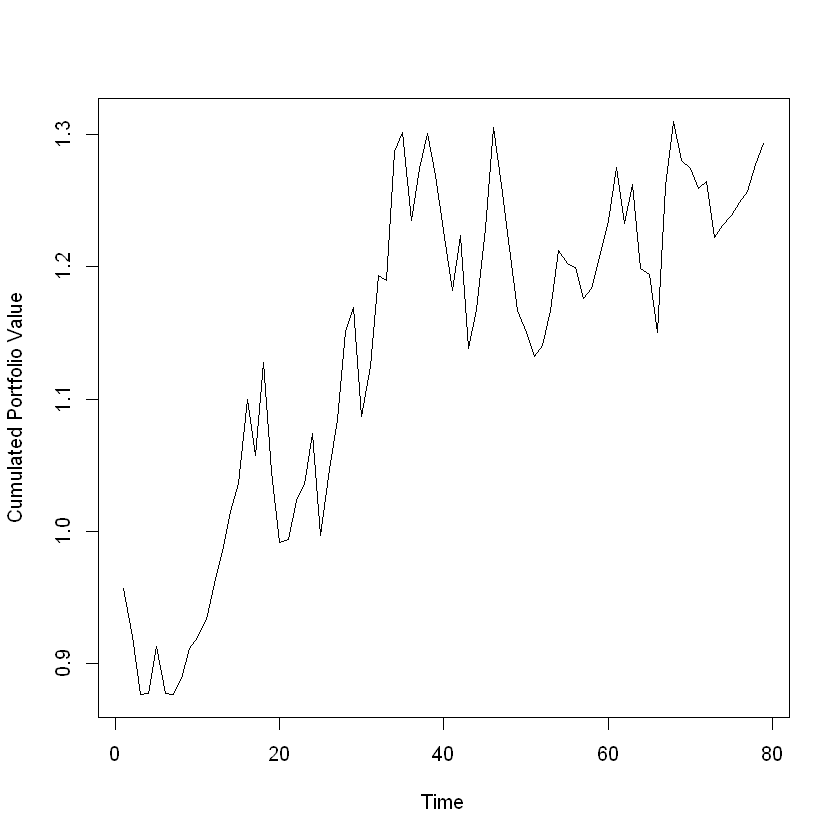

In [372]:
# Performance across time
plot_performance <- function(prediction_data){
    port_ret <- unique(prediction_data[,c("date", "log_portfolio_monthly_ret")])
    port_ret <- port_ret[order(date),]
    port_ret <- port_ret[, cumulated_portfolio_val := 1 + cumsum(log_portfolio_monthly_ret)]

    # Plot
    plot(port_ret[["cumulated_portfolio_val"]], type = "l", xlab = "Time", ylab = "Cumulated Portfolio Value")
}

plot_performance(prediction_data1)

## 2.2 Combined Strategy

### Weight Strategies by Their Sharpe Ratio

# 3. Out of Sample Backtest

- ## Model 1

In [351]:
# F05, F06, F13, F21, F22, F23 remain to be significant
names(data_test1)
data_test1 <- data_test[, c(1:3, 8:9, 16, 24:27)]

[1] "stock"       "date"        "fwd_returns" "F05"         "F06"        
 [6] "F13"         "F21"         "F22"         "F23"         "F24"

In [352]:
# Predict
OS_factors1 <- data_test1[, c(4:9)]
OS_prediction_data1 <- predict_ret(lm1, OS_factors1, data_test1, "fwd_returns_test")
head(OS_prediction_data1)
dim(OS_prediction_data1)
length(unique(OS_prediction_data1$date))

stock,date,fwd_returns,fwd_returns_predict,fwd_returns_test
S000,D107,0.22727760,-0.13749558,0.0313834726
S000,D108,-0.34961428,0.04204611,-0.0261449693
S000,D109,0.60325183,-0.04496968,0.0688761340
S000,D110,0.52747873,-0.04662204,0.0613199376
S000,D111,-0.09071276,-0.03482560,-0.0003269577
S000,D112,0.12411207,-0.02842655,0.0210956664


[1] 20618     5

[1] 35

Average number of stocks in the whole market per day:
[1] 589.1664
Sharpe Ratio:
[1] 1.119053

[1] "mean: "              "0.00370742408119525"

[1] "sd: "               "0.0425254162524194"


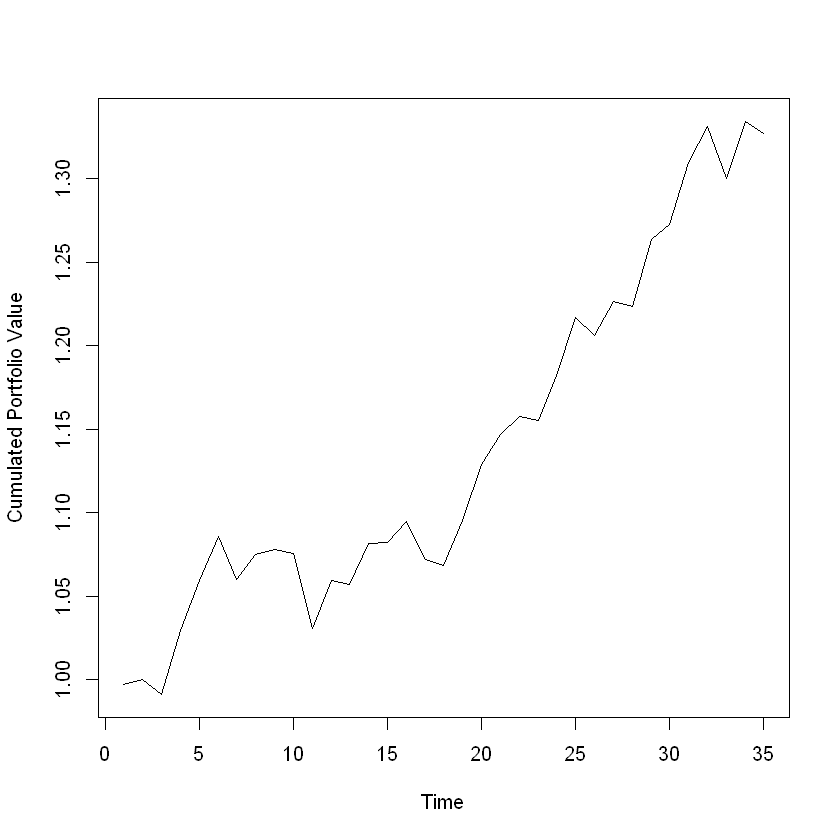

In [373]:
# Performance
OS_prediction_data1 <- decide_long_short(OS_prediction_data1)
OS_prediction_data1 <- cal_port_ret(OS_prediction_data1)
OS_prediction_data1 <- cal_SR(OS_prediction_data1)
plot_performance(OS_prediction_data1)

- ## Model 2

- ## Combined Model